# Plot Schematics

Updated February 13, 2022

1. Plot 3 different learning rate schedules

2. Plot Summary Figure

3. Plot Baseline comparison with vanilla CLRs and multiplicative CLR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pickle
import os
import time
import math
from scipy.signal import find_peaks

#import wandb

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Colab\ Notebooks/Mosaic\ Blogpost/Data-2022-02-06

/content/gdrive/MyDrive/Colab Notebooks/Mosaic Blogpost/Data-2022-02-06


In [ ]:
with open('df_ssr_baseline.pickle', 'rb') as handle:
    df_ssr_baseline = pickle.load(handle)

with open('df_ssr_methods.pickle', 'rb') as handle:
    df_ssr_methods = pickle.load(handle)

with open('df_clr_methods.pickle', 'rb') as handle:
    df_clr_methods = pickle.load(handle)

### Save Folder

In [ ]:
save = True

folder = '../Figures-2022-03-14'

## Plot Learning Rate Schedule

In [ ]:
def _extract_history(entity, project, 
                   keys= ["trainer/global_step","lr-SGD/pg1","acc/val","wall_clock_train"],
                   filter_fn=None,
                   verbose=False,**kwargs):
  
  """ Extract numpy arrays of peak values based on acc/val curve

  Unlike get_df() above, this function needs data from various timepoints during 
  training. W&B stores iteration history in run.scan_history(). This function 
  extracts this data and stores it in a dictionary. 
  
  Args
  ----
  entity
  project
  keys: list of strings, default "trainer/global_step","lr-SGD/pg1","acc/val","wall_clock_train"
  filter_fn
  
  Returns
  -------
  run_dict: dict
  """

  runs = api.runs(f"{entity}/{project}")


  run_dict={}
  for k in keys:
    run_dict[k] = []

  run_dict["name"] = []

  for run in runs: 
      if run.state != "finished":
        continue
      
      if filter_fn is not None and not filter_fn(run):
        continue

      d = run.scan_history() # WandB convention, returns iterable

      run_dict['name'] = run.name

      if verbose: 
        print(run.name)
        print(run.config['run_name'])

      for k in keys:
        # e.g. acc = [row["acc/val"] for row in run.scan_history(keys=['acc/val'])]
        val_list = [row[k] for row in run.scan_history(keys=[k])]

        run_dict[k].append(np.array(val_list))

  # store as np.array for convenient plotting
  for k in keys:
    run_dict[k] = np.array(run_dict[k]).T

  return run_dict







def get_run_dict(entity, project, filter_fn=None,
                 baseline_norm=1,
                 height=None, # for lr schedule
                 distance=5,
                 include_end=True,
                 wct_replace_epochs = 0,
                 max_val_ds=5,
                 plot=False,
                 verbose=False,
                 optim_str="lr-DecoupledSGDW/group0", **kwargs):

  """ Extract Traces from run history and save in DataFrame

  Maximum validation accuracy for cyclic learning rates is extracted via learning
  rate troughs. This function returns a pd.DataFrame with a similar structure to get_df()

  The values extracted from the wandb run are: 
  * "trainer/global_step"
  * optim_str (default in the new code base is "lr-DecoupledSGDW/group0", previously it was "lr-SGD/pg1")
  * "accuracy/val"
  * "wall_clock_train"

  Values calculated/stored in the pandas DataFrame are:
  * "Name" (as the DataFrame index)
  * "max_acc/val" - this keeps track of the maximum accuracy/validation
  * "max_acc/val.err" - std of maximum acc/val
  * "acc/val.err" - std of acc/val
  * "wall_clock_train/corrected" - Correct wall clock train by replacing first N epochs with speed of (N+1)-th epoch
  * "lr-sum" - this single number is the sum of all lr values (i.e. sum under the curve)

  Args
  ----
  entity (str): e.g. "mosaic-ml"
  project (str): project name in wandb, e.g. "i1k_clr_sweep"
  filter_fn (lambda): function used to select subset of runs, e.g. lambda run: (run.name == 'res50_cwr_T0_10ep_Tmult_2')
  baseline_norm:1,
  height (float): default None, required height of peaks used for scipy.signal.find_peaks
  distance: int, distance between peaks used in scipy.signal.find_peaks
  include_end=True, whether to include final point in training regardless of 
      learning rate schedule
  max_val_ds: int, keep track of max_acc/val within 5 steps
  plot: bool, plot for debugging
  verbose: bool

  Returns
  -------
  df: pandas DataFrame, with columns "trainer/global_step","lr-SGD/pg1",
      "acc/val","wall_clock_train","wall_clock_train/corrected"
  
  """

  # extract run history
  run_dict = _extract_history(entity, project, 
                   keys= ["trainer/global_step", optim_str,"accuracy/val","wall_clock_train"], # changed from "acc/val"
                   filter_fn=filter_fn)

    
  return run_dict

In [ ]:

!pip install wandb matplotlib pandas numpy
!export WANDB_API_KEY="b393c8277e9c2d7775849445befa5046edf69f8b"
api = wandb.Api()

     |████████████████████████████████| 1.7 MB 3.2 MB/s 
     |████████████████████████████████| 181 kB 52.7 MB/s 
     |████████████████████████████████| 144 kB 55.7 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=30b2f09024086fed3f53482719fb27d94ac0f3c383f293873d785c1e73a04c98
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


NameError: ignored

In [ ]:
project = "i1k_ssr_baseline"
filter_fn = lambda run: (('res50_ssr_0.5' in run.name) or ('res50_ssr_1' in run.name) or ('res50_ssr_2.845' in run.name)) and (run.summary["trainer/algorithms"] == ["ScaleSchedule"])

example_ssr = get_run_dict(entity, project, filter_fn, wct_replace_epochs=0, plot=True, verbose=False) # notice get trace
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
entity = "mosaic-ml"
project = "i1k_clr_sweep"
filter_fn = lambda run: (run.name == 'res50_cwr_T0_8ep_Tmult_2') and (run.summary["trainer/algorithms"] == [])

example_clr_mult = get_run_dict(entity, project, filter_fn, wct_replace_epochs=0, plot=True, verbose=False) # notice get trace



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
project = "i1k_clr_sweep"
filter_fn = lambda run: (run.name == 'res50_cwr_T0_25ep_Tmult_1') and (run.summary["trainer/algorithms"] == [])

example_clr_vanilla = get_run_dict(entity, project, filter_fn, wct_replace_epochs=0, plot=True, verbose=False) # notice get trace
  


In [ ]:
pwd

'/content/gdrive/MyDrive/Colab Notebooks/Mosaic Blogpost/Data-2022-02-06'

In [ ]:
# os.chdir(folder)
# with open('example_ssr_data.pickle', 'wb') as handle:
#     pickle.dump(example_ssr, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('example_clr_vanilla_data.pickle', 'wb') as handle:
#     pickle.dump(example_clr_vanilla, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('example_clr_mult_data.pickle', 'wb') as handle:
#     pickle.dump(example_clr_mult, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
os.chdir('../Figures-2022-02-13')
with open('example_ssr_data.pickle', 'rb') as handle:
    example_ssr = pickle.load(handle)

with open('example_clr_vanilla_data.pickle', 'rb') as handle:
    example_clr_vanilla = pickle.load(handle)

with open('example_clr_mult_data.pickle', 'rb') as handle:
    example_clr_mult = pickle.load(handle)

## Plot as example schematic

In [ ]:
example_ssr.keys()

dict_keys(['trainer/global_step', 'lr-DecoupledSGDW/group0', 'accuracy/val', 'wall_clock_train', 'name'])

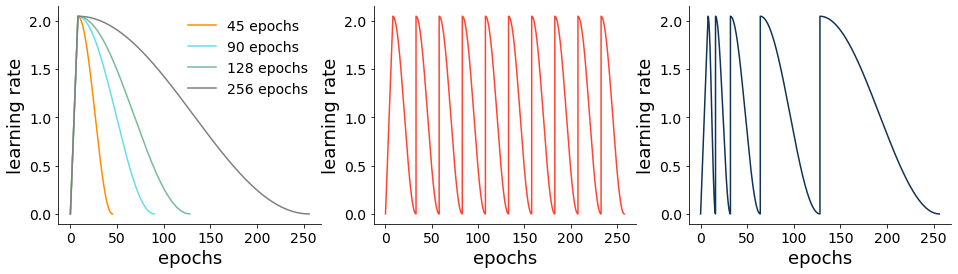

saved in ../Figures-2022-03-14/Example-LRSchedules.pdf


In [ ]:
c = ['#135','grey','#6de','#7b9','#f88','darkorange','orchid','#f43']

fig,ax = plt.subplots(1,3,figsize=(16,4))

lr0 = example_ssr['lr-DecoupledSGDW/group0']
lr1 = example_clr_vanilla['lr-DecoupledSGDW/group0']
lr2 = example_clr_mult['lr-DecoupledSGDW/group0']


sc = 0.0016
ax[0].plot(np.arange(len(lr0[12]))*sc,lr0[12],color=c[5],label='45 epochs')
ax[0].plot(np.arange(len(lr0[5]))*sc,lr0[5],color=c[2],label='90 epochs')
ax[0].plot(np.arange(len(lr0[4]))*sc,lr0[4],color=c[3],label='128 epochs')
ax[0].plot(np.arange(len(lr0[1]))*sc,lr0[1],color=c[1],label='256 epochs')


ax[1].plot(np.arange(len(lr1[:161250]))*sc,lr1[:161250],color=c[7])
ax[2].plot(np.arange(len(lr2[0][:160000]))*sc,lr2[0][:160000],color=c[0])

# Hide the right and top spines
xlabel='epochs'
ylabel = 'learning rate'
fntsz1=18
fntsz2=14
for a in ax:
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  
  a.set_ylabel(ylabel,fontsize=fntsz1)
  a.set_xlabel(xlabel,fontsize=fntsz1)

  a.tick_params(axis='x', labelsize=fntsz2)
  a.tick_params(axis='y', labelsize=fntsz2)



ax[0].legend(fontsize=fntsz2,frameon = False)




plt.show()

if save:
  fig.savefig(folder+'/Example-LRSchedules.pdf')
  print('saved in '+folder+'/Example-LRSchedules.pdf')

In [ ]:
for i in range(12):
  print(i,'epochs = {:.3f}'.format(lr0[i].shape[0]*0.0016),'ssr = {:.3f}'.format(lr0[i].shape[0]*0.0016125/90))

0 epochs = 90.000 ssr = 1.008
1 epochs = 256.000 ssr = 2.867
2 epochs = 128.000 ssr = 1.433
3 epochs = 256.000 ssr = 2.867
4 epochs = 128.000 ssr = 1.433
5 epochs = 90.000 ssr = 1.008
6 epochs = 45.000 ssr = 0.504
7 epochs = 135.000 ssr = 1.512
8 epochs = 108.000 ssr = 1.209
9 epochs = 112.000 ssr = 1.254
10 epochs = 135.000 ssr = 1.512
11 epochs = 108.000 ssr = 1.209


In [ ]:
258/161250

0.0016

## Plot val/accuracy

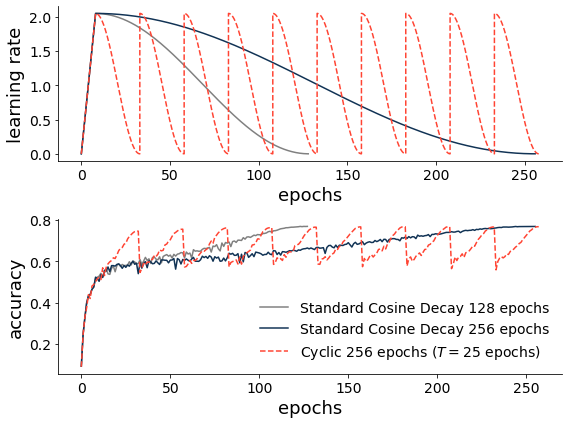

saved in ../Figures-2022-03-14/Constant-Cyclic-LR.pdf


In [ ]:
c = ['#135','grey','#6de','#7b9','#f88','darkorange','orchid','#f43']

lr1 = example_clr_vanilla['lr-DecoupledSGDW/group0']
acc1 = example_clr_vanilla['accuracy/val']
lr0 = example_ssr['lr-DecoupledSGDW/group0']
acc0 = example_ssr['accuracy/val']




fig,ax = plt.subplots(2,1,figsize=(8,6))

sc = 0.0016

ax[0].plot(np.arange(len(lr0[4][:160000]))*sc,lr0[4][:160000],color=c[1])
ax[0].plot(np.arange(len(lr0[3][:160000]))*sc,lr0[3][:160000],color=c[0])
ax[1].plot(acc0[4][:256],color=c[1])
ax[1].plot(acc0[3][:256],color=c[0])


ax[0].plot(np.arange(len(lr1[:161250]))*sc,lr1[:161250],'--',color=c[7])
ax[1].plot(acc1[:258],'--',color=c[7])




# Hide the right and top spines
xlabel='epochs'
ylabel = 'learning rate'
fntsz1=18
fntsz2=14
for a in ax:
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  
  a.set_xlabel(xlabel,fontsize=fntsz1)

  a.tick_params(axis='x', labelsize=fntsz2)
  a.tick_params(axis='y', labelsize=fntsz2)

ax[0].set_ylabel(ylabel,fontsize=fntsz1)
ax[1].set_ylabel('accuracy',fontsize=fntsz1)
ax[1].legend(['Standard Cosine Decay 128 epochs','Standard Cosine Decay 256 epochs','Cyclic 256 epochs ('+r'$T=25$'+ ' epochs)'],fontsize=fntsz2,frameon=False)

plt.tight_layout()
plt.show()

if save:
  fig.savefig(folder+'/Constant-Cyclic-LR.pdf')
  print('saved in '+folder+'/Constant-Cyclic-LR.pdf')

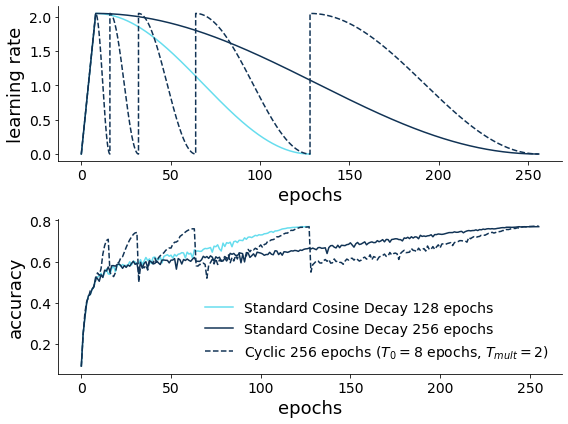

saved in ../Figures-2022-03-14/Mult-Cyclic-LR.pdf


In [ ]:
c = ['#135','grey','#6de','#7b9','#f88','darkorange','orchid','#f43']

lr2 = example_clr_mult['lr-DecoupledSGDW/group0']
acc2 = example_clr_mult['accuracy/val']


fig,ax = plt.subplots(2,1,figsize=(8,6))

sc = 0.0016

ax[0].plot(np.arange(len(lr0[4][:160000]))*sc,lr0[4][:160000],color=c[2])
ax[0].plot(np.arange(len(lr0[3][:160000]))*sc,lr0[3][:160000],color=c[0])
ax[1].plot(acc0[4][:256],color=c[2])
ax[1].plot(acc0[3][:256],color=c[0])


ax[0].plot(np.arange(len(lr2[0][:160000]))*sc,lr2[0][:160000],'--',color=c[0])
ax[1].plot(acc2[0][:256],'--',color=c[0])



# Hide the right and top spines
xlabel='epochs'
ylabel = 'learning rate'
fntsz1=18
fntsz2=14
for a in ax:
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  
  a.set_xlabel(xlabel,fontsize=fntsz1)

  a.tick_params(axis='x', labelsize=fntsz2)
  a.tick_params(axis='y', labelsize=fntsz2)

ax[0].set_ylabel(ylabel,fontsize=fntsz1)
ax[1].set_ylabel('accuracy',fontsize=fntsz1)
ax[1].legend(['Standard Cosine Decay 128 epochs','Standard Cosine Decay 256 epochs','Cyclic 256 epochs ('+r'$T_0=8$'+ ' epochs, '+r'$T_{mult}=2$)'],fontsize=fntsz2,frameon=False)
plt.tight_layout()
plt.show()

if save:
  fig.savefig(folder+'/Mult-Cyclic-LR.pdf')
  print('saved in '+folder+'/Mult-Cyclic-LR.pdf')

## Plot the same thing but with SSR as well

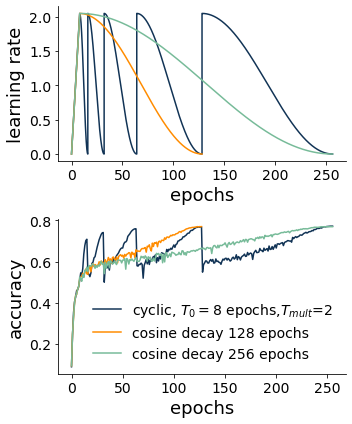

saved in ../Figures-2022-03-14/Example-LRSchedules-Teaser.pdf


In [ ]:
c = ['#135','grey','#6de','#7b9','#f88','darkorange','orchid','#f43']
lr0 = example_ssr['lr-DecoupledSGDW/group0']
acc0 = example_ssr['accuracy/val']

lr2 = example_clr_mult['lr-DecoupledSGDW/group0']
acc2 = example_clr_mult['accuracy/val']


fig,ax = plt.subplots(2,1,figsize=(5,6))

sc = 0.0016

ax[0].plot(np.arange(len(lr2[0][:160000]))*sc,lr2[0][:160000],color=c[0])
ax[0].plot(np.arange(len(lr0[4][:160000]))*sc,lr0[4][:160000],color=c[5])
ax[0].plot(np.arange(len(lr0[3][:160000]))*sc,lr0[3][:160000],color=c[3])
ax[1].plot(acc2[0][:256],color=c[0])
ax[1].plot(acc0[4][:256],color=c[5])
ax[1].plot(acc0[3][:256],color=c[3])



# Hide the right and top spines
xlabel='epochs'
ylabel = 'learning rate'
fntsz1=18
fntsz2=14
for a in ax:
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  
  a.set_xlabel(xlabel,fontsize=fntsz1)

  a.tick_params(axis='x', labelsize=fntsz2)
  a.tick_params(axis='y', labelsize=fntsz2)

ax[0].set_ylabel(ylabel,fontsize=fntsz1)
ax[1].set_ylabel('accuracy',fontsize=fntsz1)
ax[1].legend(['cyclic, '+r'$T_0=8$ epochs,'+r'$T_{mult}$=2','cosine decay 128 epochs','cosine decay 256 epochs'],fontsize=fntsz2,frameon=False)

plt.tight_layout()
plt.show()

if save:
  fig.savefig(folder+'/Example-LRSchedules-Teaser.pdf')
  print('saved in '+folder+'/Example-LRSchedules-Teaser.pdf')

## Plot Vanilla CLR

I need to load the correct data using `mult_1` and then simply plot it!

In [ ]:
#@title
def _extract_history(entity, project, 
                   keys= ["trainer/global_step","lr-SGD/pg1","acc/val","wall_clock_train"],
                   filter_fn=None,
                   verbose=False,**kwargs):
  
  """ Extract numpy arrays of peak values based on acc/val curve

  Unlike get_df() above, this function needs data from various timepoints during 
  training. W&B stores iteration history in run.scan_history(). This function 
  extracts this data and stores it in a dictionary. 
  
  Args
  ----
  entity
  project
  keys: list of strings, default "trainer/global_step","lr-SGD/pg1","acc/val","wall_clock_train"
  filter_fn
  
  Returns
  -------
  run_dict: dict
  """

  runs = api.runs(f"{entity}/{project}")


  run_dict={}
  for k in keys:
    run_dict[k] = []

  run_dict["name"] = []

  for run in runs: 
      if run.state != "finished":
        continue
      
      if filter_fn is not None and not filter_fn(run):
        continue

      d = run.scan_history() # WandB convention, returns iterable

      run_dict['name'] = run.name

      if verbose: 
        print(run.name)
        print(run.config['run_name'])

      for k in keys:
        # e.g. acc = [row["acc/val"] for row in run.scan_history(keys=['acc/val'])]
        val_list = [row[k] for row in run.scan_history(keys=[k])]

        run_dict[k].append(np.array(val_list))

  # store as np.array for convenient plotting
  for k in keys:
    run_dict[k] = np.array(run_dict[k]).T

  return run_dict







def get_clr_df(entity, project, filter_fn=None,
                 baseline_norm=1,
                 height=None, # for lr schedule
                 distance=5,
                 include_end=True,
                 wct_replace_epochs = 0,
                 max_val_ds=5,
                 plot=False,
                 verbose=False,
                 optim_str="lr-DecoupledSGDW/group0", **kwargs):

  """ Extract Traces from run history and save in DataFrame

  Maximum validation accuracy for cyclic learning rates is extracted via learning
  rate troughs. This function returns a pd.DataFrame with a similar structure to get_df()

  The values extracted from the wandb run are: 
  * "trainer/global_step"
  * optim_str (default in the new code base is "lr-DecoupledSGDW/group0", previously it was "lr-SGD/pg1")
  * "accuracy/val"
  * "wall_clock_train"

  Values calculated/stored in the pandas DataFrame are:
  * "Name" (as the DataFrame index)
  * "max_acc/val" - this keeps track of the maximum accuracy/validation
  * "max_acc/val.err" - std of maximum acc/val
  * "acc/val.err" - std of acc/val
  * "wall_clock_train/corrected" - Correct wall clock train by replacing first N epochs with speed of (N+1)-th epoch
  * "lr-sum" - this single number is the sum of all lr values (i.e. sum under the curve)

  Args
  ----
  entity (str): e.g. "mosaic-ml"
  project (str): project name in wandb, e.g. "i1k_clr_sweep"
  filter_fn (lambda): function used to select subset of runs, e.g. lambda run: (run.name == 'res50_cwr_T0_10ep_Tmult_2')
  baseline_norm:1,
  height (float): default None, required height of peaks used for scipy.signal.find_peaks
  distance: int, distance between peaks used in scipy.signal.find_peaks
  include_end=True, whether to include final point in training regardless of 
      learning rate schedule
  max_val_ds: int, keep track of max_acc/val within 5 steps
  plot: bool, plot for debugging
  verbose: bool

  Returns
  -------
  df: pandas DataFrame, with columns "trainer/global_step","lr-SGD/pg1",
      "acc/val","wall_clock_train","wall_clock_train/corrected"
  
  """

  # extract run history
  run_dict = _extract_history(entity, project, 
                   keys= ["trainer/global_step", optim_str,"accuracy/val","wall_clock_train"], # changed from "acc/val"
                   filter_fn=filter_fn)
  
  df = pd.DataFrame({'Name':[],
                     "trainer/global_step":[],
                     optim_str:[], 
                     "accuracy/val":[],"max_acc/val":[],
                     "wall_clock_train":[],
                     "wall_clock_train/corrected":[],
                     "lr-sum":[],
                     "lr-full":[],
                     "wct-full":[],
                     "acc-full":[]}).set_index('Name')

  
  for tgs,wct,lr,acc in zip(run_dict["trainer/global_step"].T,run_dict["wall_clock_train"].T,run_dict[optim_str].T,run_dict["accuracy/val"].T,):
    
    """Find peaks/troughs by learning rate schedule curve
    Note: For SGDR (cyclic cosine + restart), can find troughs via sign flip
    """
    troughs,_ = find_peaks(-lr, height=height, threshold=None, distance=distance) 
    
    troughs_max_val,_ = find_peaks(acc, height=height, threshold=None, distance=distance) 

    # find_peaks compares neighboring values, and therefore neglects final iteration
    # if it is monotonically decreasing. This can happen when cycles don't exactly
    # match the total alotted training budget. "include_end" therefore includes 
    # last index
    if include_end:
      troughs = np.append(troughs,len(lr)-1)

    # maintain copy for calculating sum
    troughs_true = np.copy(troughs)

    # In scenario that lr schedule is oversampled. Currently, "acc/val" is only logged
    # at the end of each epoch
    if len(lr) >= len(acc):
      if verbose: print('>> downsample learning rate log \n')
      ds = len(lr)/len(acc)
      
      troughs = [int(tr/ds) for tr in troughs]


    # Correct wall clock train by replacing first N epochs with speed of (N+1)-th epoch
    if wct_replace_epochs > 0:
      wre = wct_replace_epochs
      corrected_wct = wct - wct[wre - 1] + (wre) * (wct[wre] - wct[wre-1])
    else:
      corrected_wct = wct

    max_vals = [ np.max(acc[tr-max_val_ds:tr+max_val_ds]) for tr in troughs]
    max_vals_ind = [np.where(acc==m)[0][0] for m in max_vals]

    if verbose: 
      print('wct[troughs]: ',wct[troughs])
      print('corrected_wct[troughs]: ',corrected_wct[troughs])

    if plot:
      print('>> Plot=True')
      fig1,ax1 = plt.subplots(2,1,figsize=(20,10))  
      ax1[0].plot(lr,linewidth=2)
      ax1[1].plot(wct,acc,linewidth=2)
      ax1[1].plot(wct[troughs], acc[troughs], "x",color='r',markersize=15,label='LR trough')
      ax1[1].plot(wct[max_vals_ind], acc[max_vals_ind], "x",color='g',markersize=15,label='local maximum')
      ax1[1].legend()

      for a in ax1:
        a.set_xlabel('wall_clock_time',fontsize=14)
        a.set_ylabel('accuracy/val',fontsize=14)
        a.tick_params(axis='both', which='major', labelsize=14)
      
      plt.show()

      fig2,ax2 = plt.subplots(1,1)

    speedup = baseline_norm/np.round(wct[troughs])
    speedup = baseline_norm/np.round(wct[troughs])

    if verbose: print('speedup:',speedup)
    
    if plot:
      ax2.plot(speedup,acc[troughs],'o')
      ax2.set_xscale('log')

    if plot:
      fig3,ax3 = plt.subplots(1,1)
      for tr in troughs_true:
        ax3.plot(lr[:tr])
      plt.show()

    # TODO: include full trace
    #"lr-full":lr,
    #"wct-full":wct,
    #"acc-full":acc

    df1 = pd.DataFrame({'Name':[run_dict["name"]+"-"+str(i) for i in range(len(troughs))],"trainer/global_step":tgs[troughs], \
                        optim_str:lr[troughs],"acc/val":acc[troughs],
                        "max_acc/val":acc[max_vals_ind],
                        "wall_clock_train":wct[troughs],
                        "wall_clock_train/corrected":corrected_wct[troughs],
                        "lr-sum":[np.sum(lr[:tr]) for tr in troughs_true]}).set_index('Name')
    df = df.append(df1)

    if verbose: print(df)

    # Average by Name
    var_df = df.groupby("Name").var().applymap(lambda x: math.sqrt(x))
    avg_df = df.groupby("Name").mean()
    avg_df['max_acc/val.err'] = var_df['max_acc/val']
    avg_df['acc/val.err'] = var_df['accuracy/val']
    
  return avg_df


CLR (const): T=10 epochs lr-DecoupledSGDW/group0
>> downsample learning rate log 

wct[troughs]:  [ 4931.74823713  7674.25571895 10416.05259323 13158.08416367
 15900.84669542 18643.1462574  21385.89385462 24127.63142896
 26870.410079   29611.83480692 32354.35261416 35096.52517271
 37838.07189202 40579.96439719 43322.23988461 46063.96536374
 48805.1831286  51547.7851131  54289.50087667 57032.16597199
 59773.41661549 62515.44476819 65258.21398377 68001.13658619
 70743.83406019]
corrected_wct[troughs]:  [ 4931.74823713  7674.25571895 10416.05259323 13158.08416367
 15900.84669542 18643.1462574  21385.89385462 24127.63142896
 26870.410079   29611.83480692 32354.35261416 35096.52517271
 37838.07189202 40579.96439719 43322.23988461 46063.96536374
 48805.1831286  51547.7851131  54289.50087667 57032.16597199
 59773.41661549 62515.44476819 65258.21398377 68001.13658619
 70743.83406019]
>> Plot=True


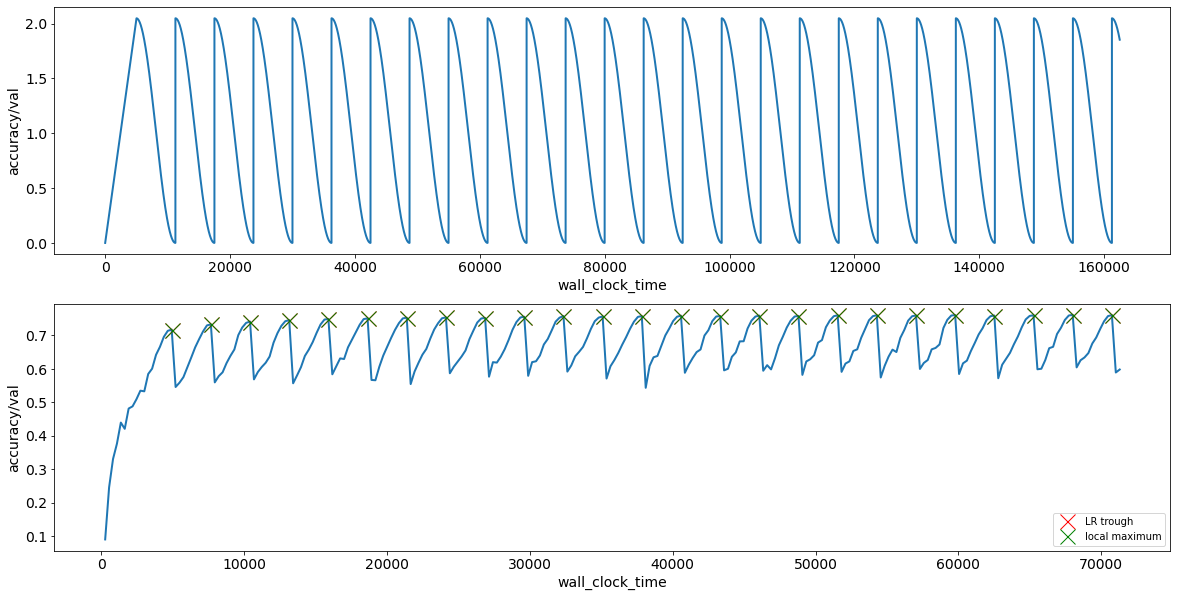

speedup: [2.02757502e-04 1.30310138e-04 9.60061444e-05 7.59993920e-05
 6.28891265e-05 5.36394357e-05 4.67595623e-05 4.14456233e-05
 3.72162263e-05 3.37700932e-05 3.09080794e-05 2.84924637e-05
 2.64284582e-05 2.46426811e-05 2.30829602e-05 2.17089267e-05
 2.04897039e-05 1.93993947e-05 1.84195985e-05 1.75340160e-05
 1.67299617e-05 1.59961609e-05 1.53237917e-05 1.47056661e-05
 1.41354744e-05]


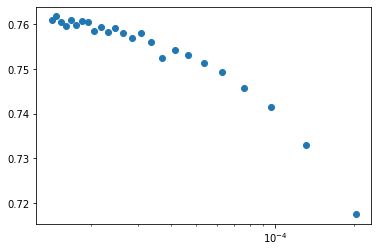

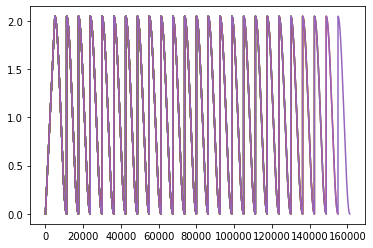

                              trainer/global_step  ...  acc/val
Name                                               ...         
res50_cwr_T0_10ep_Tmult_1-0                  17.0  ...  0.71756
res50_cwr_T0_10ep_Tmult_1-1                  27.0  ...  0.73304
res50_cwr_T0_10ep_Tmult_1-2                  37.0  ...  0.74150
res50_cwr_T0_10ep_Tmult_1-3                  47.0  ...  0.74580
res50_cwr_T0_10ep_Tmult_1-4                  57.0  ...  0.74924
res50_cwr_T0_10ep_Tmult_1-5                  67.0  ...  0.75128
res50_cwr_T0_10ep_Tmult_1-6                  77.0  ...  0.75316
res50_cwr_T0_10ep_Tmult_1-7                  87.0  ...  0.75414
res50_cwr_T0_10ep_Tmult_1-8                  97.0  ...  0.75254
res50_cwr_T0_10ep_Tmult_1-9                 107.0  ...  0.75602
res50_cwr_T0_10ep_Tmult_1-10                117.0  ...  0.75804
res50_cwr_T0_10ep_Tmult_1-11                127.0  ...  0.75686
res50_cwr_T0_10ep_Tmult_1-12                137.0  ...  0.75806
res50_cwr_T0_10ep_Tmult_1-13            

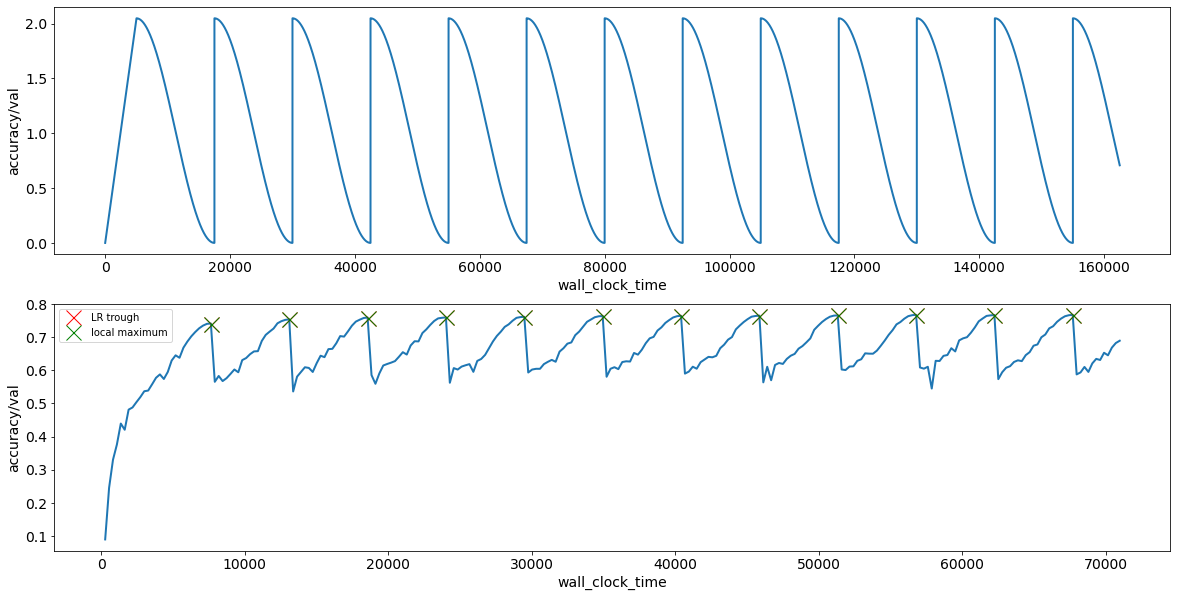

speedup: [1.30872922e-04 7.63184004e-05 5.38647994e-05 4.16250416e-05
 3.39120998e-05 2.86131220e-05 2.47463499e-05 2.18002660e-05
 1.94806460e-05 1.76078038e-05 1.60637409e-05 1.47686491e-05]


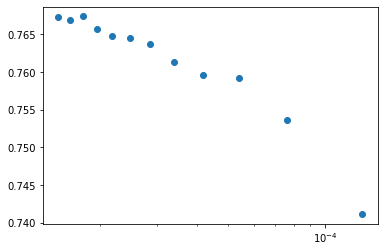

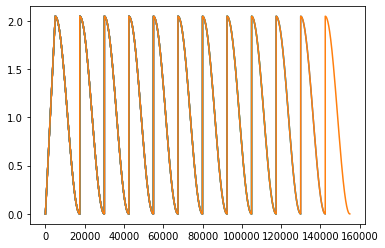

                              trainer/global_step  ...  acc/val
Name                                               ...         
res50_cwr_T0_20ep_Tmult_1-0                  27.0  ...  0.74112
res50_cwr_T0_20ep_Tmult_1-1                  47.0  ...  0.75362
res50_cwr_T0_20ep_Tmult_1-2                  67.0  ...  0.75924
res50_cwr_T0_20ep_Tmult_1-3                  87.0  ...  0.75962
res50_cwr_T0_20ep_Tmult_1-4                 107.0  ...  0.76138
res50_cwr_T0_20ep_Tmult_1-5                 127.0  ...  0.76372
res50_cwr_T0_20ep_Tmult_1-6                 147.0  ...  0.76452
res50_cwr_T0_20ep_Tmult_1-7                 167.0  ...  0.76486
res50_cwr_T0_20ep_Tmult_1-8                 187.0  ...  0.76578
res50_cwr_T0_20ep_Tmult_1-9                 207.0  ...  0.76740
res50_cwr_T0_20ep_Tmult_1-10                227.0  ...  0.76688
res50_cwr_T0_20ep_Tmult_1-11                247.0  ...  0.76726

[12 rows x 11 columns]
CLR (const): T=25 epochs lr-DecoupledSGDW/group0
>> downsample learning rate log

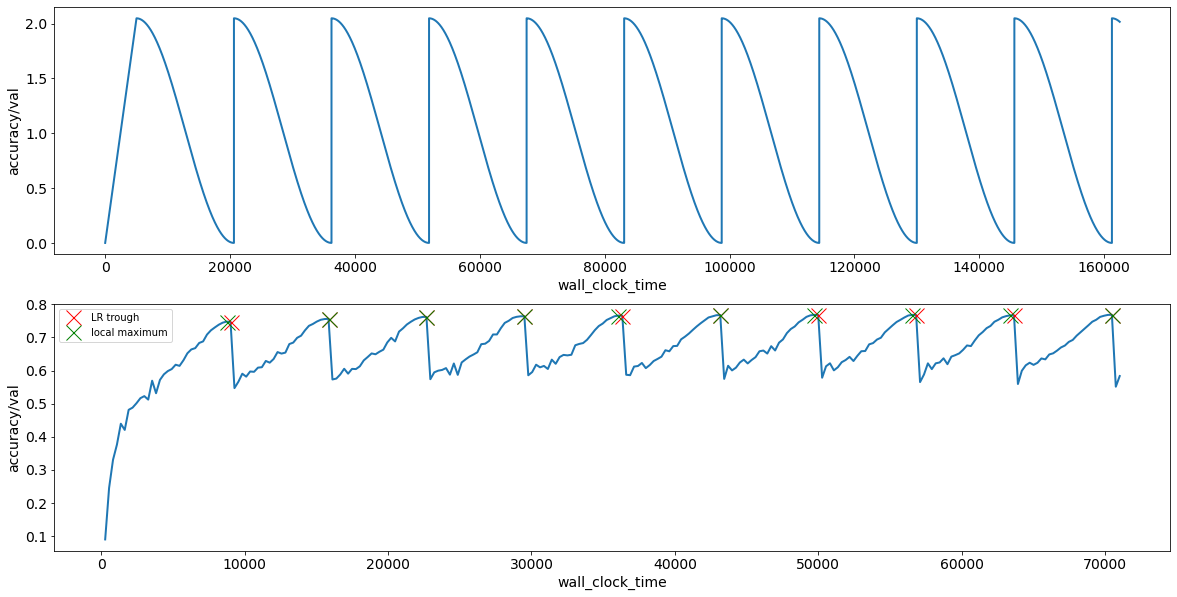

speedup: [1.10901630e-04 6.30954634e-05 4.40975438e-05 3.38902633e-05
 2.75201585e-05 2.31653076e-05 2.00004000e-05 1.75972689e-05
 1.57104254e-05 1.41888249e-05]


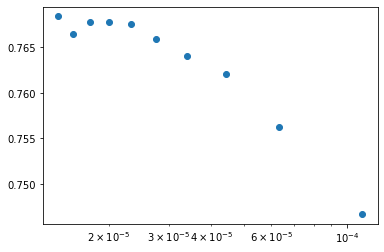

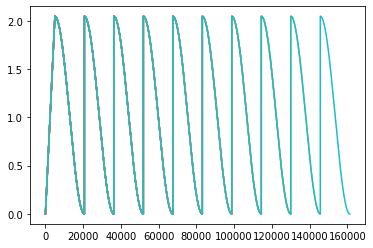

                             trainer/global_step  ...  acc/val
Name                                              ...         
res50_cwr_T0_25ep_Tmult_1-0                 32.0  ...  0.74668
res50_cwr_T0_25ep_Tmult_1-1                 57.0  ...  0.75620
res50_cwr_T0_25ep_Tmult_1-2                 82.0  ...  0.76210
res50_cwr_T0_25ep_Tmult_1-3                107.0  ...  0.76410
res50_cwr_T0_25ep_Tmult_1-4                132.0  ...  0.76588
res50_cwr_T0_25ep_Tmult_1-5                157.0  ...  0.76758
res50_cwr_T0_25ep_Tmult_1-6                182.0  ...  0.76784
res50_cwr_T0_25ep_Tmult_1-7                207.0  ...  0.76776
res50_cwr_T0_25ep_Tmult_1-8                232.0  ...  0.76646
res50_cwr_T0_25ep_Tmult_1-9                257.0  ...  0.76840

[10 rows x 11 columns]
CLR (const): T=40 epochs lr-DecoupledSGDW/group0
>> downsample learning rate log 

wct[troughs]:  [12928.16860628 23693.0725975  34456.08181882 45215.81909776
 55990.58758068 66771.90164161]
corrected_wct[troughs]:  [129

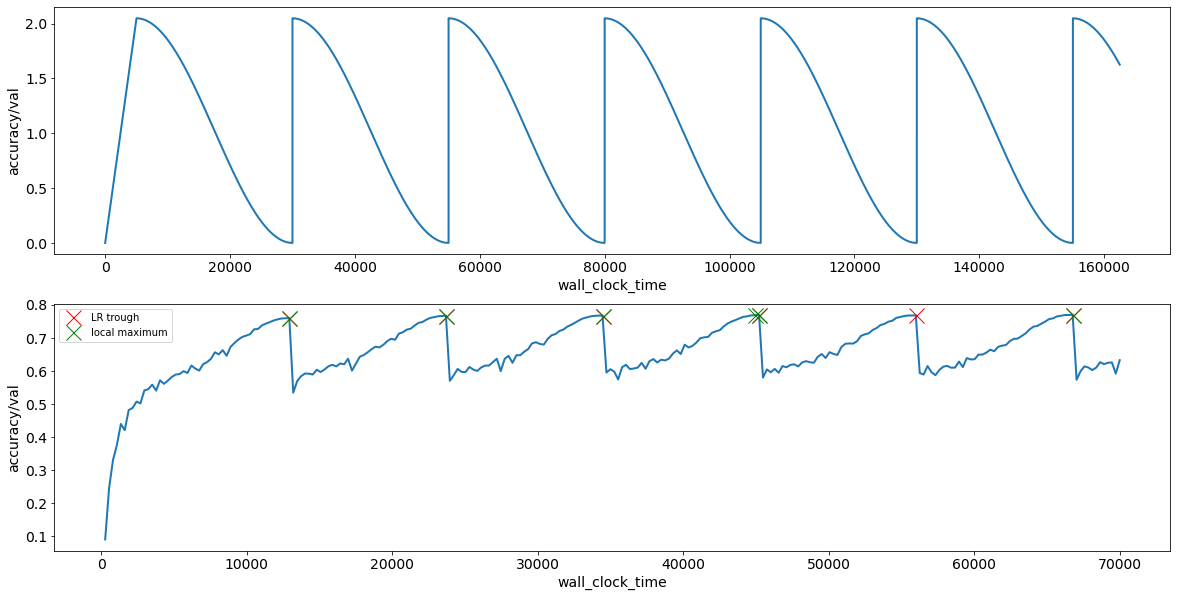

speedup: [7.73514851e-05 4.22065589e-05 2.90225215e-05 2.21160651e-05
 1.78600132e-05 1.49763374e-05]


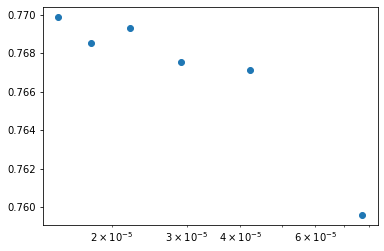

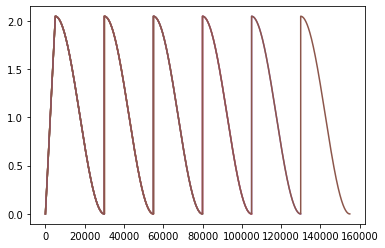

                             trainer/global_step  ...  acc/val
Name                                              ...         
res50_cwr_T0_40ep_Tmult_1-0                 47.0  ...  0.75960
res50_cwr_T0_40ep_Tmult_1-1                 87.0  ...  0.76712
res50_cwr_T0_40ep_Tmult_1-2                127.0  ...  0.76752
res50_cwr_T0_40ep_Tmult_1-3                167.0  ...  0.76930
res50_cwr_T0_40ep_Tmult_1-4                207.0  ...  0.76854
res50_cwr_T0_40ep_Tmult_1-5                247.0  ...  0.76988

[6 rows x 11 columns]
CLR (const): T=50 epochs lr-DecoupledSGDW/group0
>> downsample learning rate log 

wct[troughs]:  [15832.34075665 29488.06907272 43143.69578028 56797.90821409
 70449.64764881]
corrected_wct[troughs]:  [15832.34075665 29488.06907272 43143.69578028 56797.90821409
 70449.64764881]
>> Plot=True


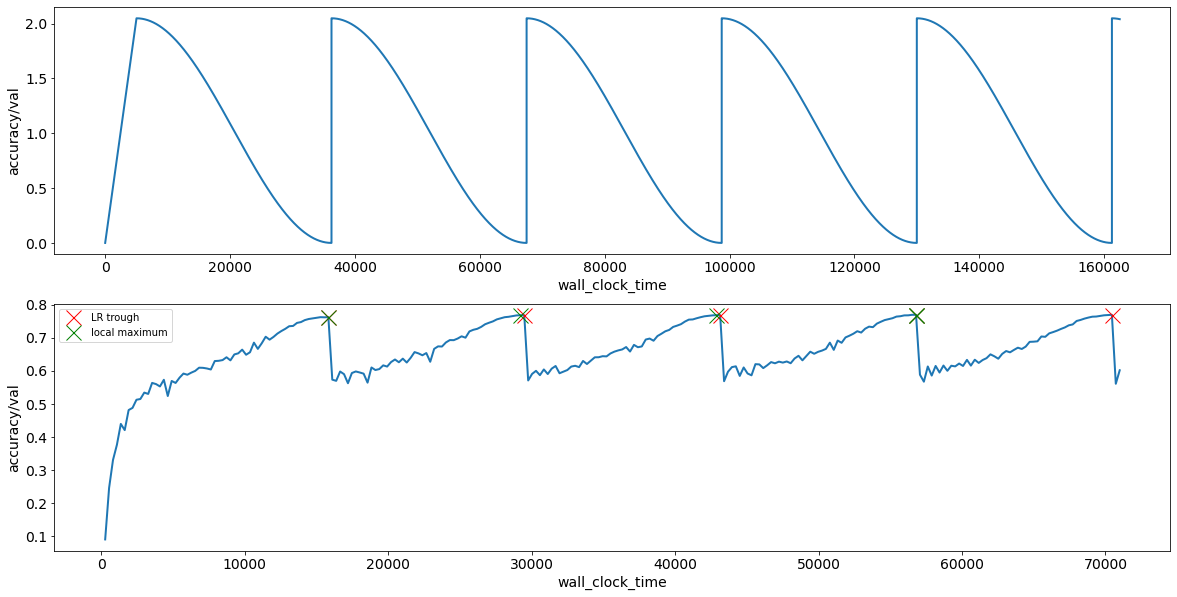

speedup: [6.31632137e-05 3.39120998e-05 2.31781940e-05 1.76062537e-05
 1.41944642e-05]


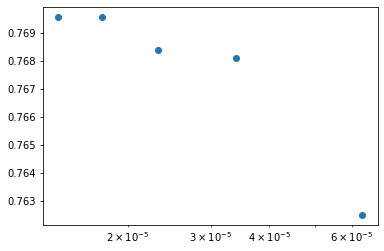

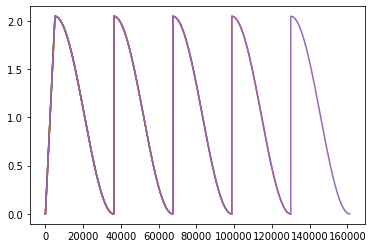

                             trainer/global_step  ...  acc/val
Name                                              ...         
res50_cwr_T0_50ep_Tmult_1-0                 57.0  ...  0.76250
res50_cwr_T0_50ep_Tmult_1-1                107.0  ...  0.76810
res50_cwr_T0_50ep_Tmult_1-2                157.0  ...  0.76840
res50_cwr_T0_50ep_Tmult_1-3                207.0  ...  0.76956
res50_cwr_T0_50ep_Tmult_1-4                257.0  ...  0.76956

[5 rows x 11 columns]

 Extract CLR data 4.5091 minutes


In [ ]:
tic = time.perf_counter()

entity = "mosaic-ml"

df_clr_constant = []

norm_wct, norm_acc = 1, 1


for (label, project, filter_fn,color) in [
                            ("CLR (const): T=10 epochs","i1k_clr_sweep", lambda run: (run.name == 'res50_cwr_T0_10ep_Tmult_1') and (run.summary["trainer/algorithms"] == []),"C0"),
                            ("CLR (const): T=20 epochs","i1k_clr_sweep", lambda run: (run.name == 'res50_cwr_T0_20ep_Tmult_1') and (run.summary["trainer/algorithms"] == []),"C1"),
                            ("CLR (const): T=25 epochs","i1k_clr_sweep", lambda run: (run.name == 'res50_cwr_T0_25ep_Tmult_1') and (run.summary["trainer/algorithms"] == []),"C2"),
                            ("CLR (const): T=40 epochs","i1k_clr_sweep", lambda run: (run.name == 'res50_cwr_T0_40ep_Tmult_1') and (run.summary["trainer/algorithms"] == []),"C3"),
                            ("CLR (const): T=50 epochs","i1k_clr_sweep", lambda run: (run.name == 'res50_cwr_T0_50ep_Tmult_1') and (run.summary["trainer/algorithms"] == []),"C4"),                      
                            ]:
  include_end = False
  optim_str = "lr-DecoupledSGDW/group0" # changed with new codecase
  print(label, optim_str)
  run_set_df = get_clr_df(entity, project, filter_fn,wct_replace_epochs = 0,baseline_norm = norm_wct,distance=5,include_end=include_end,plot=True,verbose=True, optim_str=optim_str) # notice get trace
  
  df_clr_constant.append((label, project, run_set_df,color))



toc = time.perf_counter()
print("\n Extract CLR data {:0.4f} minutes".format((toc - tic)/60))

In [ ]:
pwd

'/content/gdrive/MyDrive/Colab Notebooks/Mosaic Blogpost/Figures-2022-02-13'

In [ ]:
# Save data

# with open('df_clr_constant.pickle', 'wb') as handle:
#     pickle.dump(df_clr_constant, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_clr_constant.pickle', 'rb') as handle:
    df_clr_constant = pickle.load(handle)


In [ ]:

def plot_pareto(df_type, 
                name_list=["SSR: Baseline"], 
                WCT_CORRECTED = False, 
                MAX_ACC = True,
                fig = None,
                linestyle='-',
                time_format='hours',
                color=None,
                legend=None):

  if fig == None:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  else:
    ax = fig.gca()

  if time_format == 'minutes':
    denom = 60
  if time_format == 'hours':
    denom = 60*60

  for name in name_list:

    """ Plot Multiplicative CLR"""
    for i, (label, project, df,col) in enumerate(df_type):

      if label == name:

        if color == None:
          color = col

        if legend == None:
          legend = label

        if 'res50_ssr_0.1' in df.index:
          df = df.drop(index='res50_ssr_0.1')
          print('drop res50_ssr_0.1')

        acc = df["max_acc/val" if MAX_ACC else "acc/val"]
        wct = df["wall_clock_train/corrected" if WCT_CORRECTED else "wall_clock_train"]
        yerr = df["max_acc/val.err" if MAX_ACC else "acc/val.err"]

        # convert wct to minutes
        speed = wct/denom

        ind = np.argsort(speed)

        ax.plot(speed[ind], acc[ind]*1e2,'o',linestyle=linestyle,color=color,label=legend)
        ax.errorbar(speed[ind], acc[ind]*1e2, yerr=yerr[ind]*1e2, color=color, alpha=1, fmt='none')
        print(label+' final acc: {:.4f}'.format(acc[-1]))

      # include vertical and horizontal line for SSR baseline of 90 epochs
      if label == "SSR: Baseline":
        speed = df.loc["res50_ssr_1.0"]["wall_clock_train/corrected" if WCT_CORRECTED else "wall_clock_train"]
        acc = df.loc["res50_ssr_1.0"]["max_acc/val" if MAX_ACC else "acc/val"]
        ax.axhline(y=acc*1e2, linestyle="dotted", color='#135')
        ax.axvline(x=speed/denom, linestyle="dotted", color='#135')

        n = "16 epochs"
        s = df_ssr_baseline[0][2].loc["res50_ssr_0.175"]["wall_clock_train/corrected" if WCT_CORRECTED else "wall_clock_train"]
        a = df_ssr_baseline[0][2].loc["res50_ssr_0.175"]["max_acc/val" if MAX_ACC else "accuracy/val"]
        ax.annotate(n, (s/denom, a*1e2), horizontalalignment='left', verticalalignment='top',
                          xytext=(5, -6), textcoords='offset pixels',color='#135',fontsize=14) #

        n = "90 epochs"
        s = df_ssr_baseline[0][2].loc["res50_ssr_1.0"]["wall_clock_train/corrected" if WCT_CORRECTED else "wall_clock_train"]
        a = df_ssr_baseline[0][2].loc["res50_ssr_1.0"]["max_acc/val" if MAX_ACC else "accuracy/val"]
        ax.annotate(n, (s/denom, a*1e2), horizontalalignment='left', verticalalignment='top',
                          xytext=(5, -78), textcoords='offset pixels',color='#135',fontsize=14) #

        n = "512 epochs"
        s = df_ssr_baseline[0][2].loc["res50_ssr_5.69"]["wall_clock_train/corrected" if WCT_CORRECTED else "wall_clock_train"]
        a = df_ssr_baseline[0][2].loc["res50_ssr_5.69"]["max_acc/val" if MAX_ACC else "accuracy/val"]
        ax.annotate(n, (s/denom, a*1e2), horizontalalignment='right', verticalalignment='top',
                          xytext=(-4, -62), textcoords='offset pixels',color='#135',fontsize=14) #
        ax.axvline(x=s/denom, linestyle="dotted", color='#135')




  return fig


def format_fig(fig,
               xlabel='Wall Clock Time',
               ylabel='Accuracy/val (%)',
               fntsz1=18,
               fntsz2=14,
               xscale='log',
               ylim=[69,80],
               xlim=None,
               time_format='hours'):
  ax = fig.gca()

  if time_format=='minutes':
    xlabel=xlabel+' (minutes)'
  if time_format=='hours':
    xlabel=xlabel+' (hours)'
    ax.set_xlim([0.8,45])

  
  ax.set_ylabel(ylabel,fontsize=fntsz1)
  ax.set_xlabel(xlabel,fontsize=fntsz1)

  ax.tick_params(axis='x', labelsize=fntsz2)
  ax.tick_params(axis='y', labelsize=fntsz2)

  ax.legend(fontsize=fntsz2,loc=4)
  ax.set_xscale(xscale)
  
  if time_format == 'minutes':
    xticks = [7*1e1,1e2, 2*1e2, 4*1e2, 1e3,2*1e3]
  if time_format == 'hours':
    xticks = [1,2,3,4,5,6,7,8,10,20,30,40]
  ax.set_xticks(xticks)

  # Override how matplotlib wants to generate the ticks when you set log scale.
  # https://www.reddit.com/r/learnpython/comments/epwteg/matplotlib_ticklabels_disappearing_in_log_scale/
  ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
  #ax.minorticks_off()
  #ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

  ax.set_ylim(ylim)
  ax.yaxis.set_ticks(np.arange(ylim[0], ylim[1]+0.5,0.5))

  plt.grid(b=True, which='major')
  plt.grid(b=True, which='minor')

  return fig



drop res50_ssr_0.1
SSR: Baseline final acc: 0.7646
CLR (const): T=10 epochs final acc: 0.7560
CLR (const): T=20 epochs final acc: 0.7674
CLR (const): T=25 epochs final acc: 0.7684
CLR (const): T=40 epochs final acc: 0.7699
CLR (const): T=50 epochs final acc: 0.7696


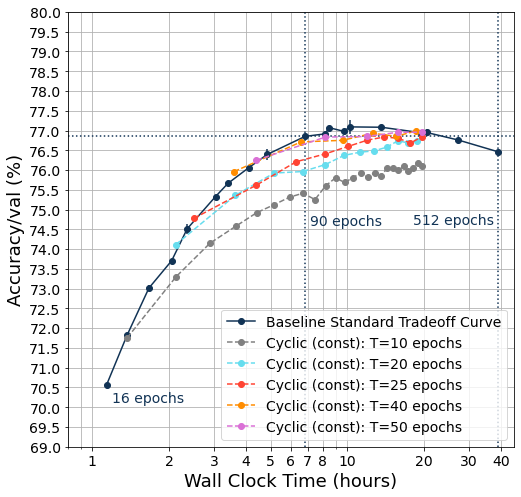

saved in ../Figures-2022-03-14/Constant-CLR-Tradeoff-Curve.pdf


In [ ]:
c = ['#135','grey','#6de','#7b9','#f88','darkorange','orchid','#f43']
fig = plot_pareto(df_ssr_baseline,name_list=["SSR: Baseline"],WCT_CORRECTED = False,color=c[0],legend='Baseline Standard Tradeoff Curve')
fig = plot_pareto(df_clr_constant,name_list=["CLR (const): T=10 epochs"],WCT_CORRECTED = False,fig=fig,linestyle='--',color=c[1],legend='Cyclic (const): T=10 epochs')
fig = plot_pareto(df_clr_constant,name_list=["CLR (const): T=20 epochs"],WCT_CORRECTED = False,fig=fig,linestyle='--',color=c[2],legend='Cyclic (const): T=20 epochs')
fig = plot_pareto(df_clr_constant,name_list=["CLR (const): T=25 epochs"],WCT_CORRECTED = False,fig=fig,linestyle='--',color=c[7],legend='Cyclic (const): T=25 epochs')
fig = plot_pareto(df_clr_constant,name_list=["CLR (const): T=40 epochs"],WCT_CORRECTED = False,fig=fig,linestyle='--',color=c[5],legend='Cyclic (const): T=40 epochs')
fig = plot_pareto(df_clr_constant,name_list=["CLR (const): T=50 epochs"],WCT_CORRECTED = False,fig=fig,linestyle='--',color=c[6],legend='Cyclic (const): T=50 epochs')

# # Plot pareto curve from single run
# denom = 60*60
# acc0 = example_ssr['accuracy/val']
# wct0 = example_ssr["wall_clock_train"]
# fig.gca().plot([wct0[3][80]/denom,wct0[3][90]/denom,wct0[3][128]/denom,wct0[3][200]/denom,wct0[3][255]/denom],[acc0[3][80]*1e2,acc0[3][90]*1e2,acc0[3][128]*1e2,acc0[3][200]*1e2,acc0[3][255]*1e2],'o-',color='r')


fig = format_fig(fig,ylim=[69,80])


plt.show()

if save:
  fig.savefig(folder+'/Constant-CLR-Tradeoff-Curve.pdf')
  print('saved in '+folder+'/Constant-CLR-Tradeoff-Curve.pdf')

In [ ]:
acc0 = example_ssr['accuracy/val']
wct0 = example_ssr["wall_clock_train"]

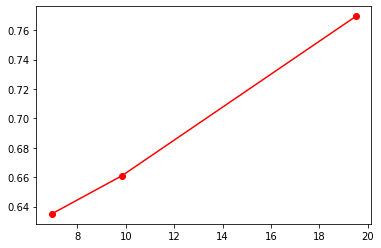

In [ ]:
plt.plot([wct0[3][90]/denom,wct0[3][128]/denom,wct0[3][255]/denom],[acc0[3][90],acc0[3][128],acc0[3][255]],'o-',color='r')

In [ ]:
wct0[3][90]/denom

6.9356183479229605